In [1]:
from sqlalchemy.orm import relationship, sessionmaker
from sqlalchemy import create_engine
from database import Reactions

engine = create_engine('sqlite:///reactions2.db', echo = False)

Session = sessionmaker(bind=engine)
session = Session()

2022-12-05 22:19:51,986 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-12-05 22:19:51,986 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("reactions")
2022-12-05 22:19:51,987 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-05 22:19:51,987 INFO sqlalchemy.engine.Engine COMMIT


In [2]:
def getRxnFP(r, fp_type, summed, multipliers):
    if fp_type == "MACCS":
        rxnMatrix = np.zeros((5,167))
    else:
        rxnMatrix = np.zeros((5,2048))
    row = 0
    for k,m in zip(reagent_classes,multipliers):
        sm = getattr(r,k)
        if sm == "NONE":
            fp = np.zeros((1,))
        else:
            if k == "solvent":
                mol = Chem.MolFromSmiles(solv_map[sm])
                if fp_type == "MACCS":
                    DataStructs.ConvertToNumpyArray(MACCSkeys.GenMACCSKeys(mol), fp)
                else:
                    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp)
                if "%" in sm:
                    s2 = sm.split("_")[1]
                    mol2 = Chem.MolFromSmiles(solv_map[s2])
                    fp2 = np.zeros((1,))
                    if fp_type == "MACCS":
                        DataStructs.ConvertToNumpyArray(MACCSkeys.GenMACCSKeys(mol), fp2)
                    else:
                        DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp2)

                    fp = np.add(fp,fp2)
            else:
                mol = Chem.MolFromSmiles(sm)
                fp = np.zeros((1,))
                if fp_type == "MACCS":
                    DataStructs.ConvertToNumpyArray(MACCSkeys.GenMACCSKeys(mol), fp)
                else:
                    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp)
        fp = fp*m
        rxnMatrix[row,:] = fp
        row = row + 1
    if summed:
        return np.sum(rxnMatrix, axis=0)
    else:
        return rxnMatrix

In [ ]:
import requests


CACTUS = "https://cactus.nci.nih.gov/chemical/structure/{0}/{1}"


def smiles_to_iupac(smiles):
    rep = "iupac_name"
    url = CACTUS.format(smiles, rep)
    response = requests.get(url)
    response.raise_for_status()
    return response.text


print(smiles_to_iupac('c1ccccc1'))
print(smiles_to_iupac('CC(=O)OC1=CC=CC=C1C(=O)O'))

In [4]:
r = session.query(Reactions).all()


/var/folders/8k/w__0g4xs7rj0xv7hk3dqm71w0000gn/T/ipykernel_13608/3822804417.py:1: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  r = session.query(Reactions).all()


In [68]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem, MACCSkeys
import pandas as pd

reagent_classes = ["electrophile", "nucleophile", "catalyst_smiles", "base_smiles", "solvent"]
solv_map = {"NMP":'O=C1N(C)CCC1', "DMSO":'O=S(C)C',"DMF":'O=CN(C)C', \
            "25%H2O_NMP":'[H]O[H].O=C1N(C)CCC1', "25%H2O_DMSO":'O=S(C)C.[H]O[H]', "25%H2O_DMF":'O=CN(C)C.[H]O[H]', \
            "25%tAmOH_DMSO":"CCC(C)(O)C.O=S(C)C","10%tAmOH_NMP":"CCC(C)(O)C.O=C1N(C)CCC1"}

multipliers = [1, 1, 1, 1, 1]
rxnfps = []
yields = []
data = {k:[] for k in reagent_classes}
smiles_to_name = {}
smiles_to_yields = {}
true_yields = []
yields_split_by_class = {k:{} for k in reagent_classes}
fps_split_by_class = {k:[] for k in reagent_classes}
ordered_smiles_by_class = {k:{} for k in reagent_classes}
remove_outlier_fp = []
for k in r:
    if "Suzuki" not in k.reaction_name:
        continue
    fp = getRxnFP(k, "MFP4", True, multipliers)
    rxnfps.append(fp)
    if float(k.output_value) <= 100:
        remove_outlier_fp.append(fp)
    true_yields.append(float(k.output_value))
    n = k.group
    if n == "0":
        yields.append(0)
    elif n == "low":
        yields.append(1)
    elif n == "med":
        yields.append(2)
    else:
        yields.append(3)
        

    for i,j in enumerate(reagent_classes):
        data[j].append(getattr(k,j))
        if j == "catalyst_smiles":
            smiles_to_name[getattr(k,j)] = k.catalyst
            if getattr(k,j) not in smiles_to_yields:
                smiles_to_yields[getattr(k,j)] = []
            smiles_to_yields[getattr(k,j)].append(k.output_value)
        if j == "base_smiles":
            smiles_to_name[getattr(k,j)] = k.base
        
        if float(k.output_value) > 100:
            continue
            

        if j=="solvent":
            mol=Chem.MolFromSmiles(solv_map[getattr(k,j)])
            sm = solv_map[getattr(k,j)]
        else:
            mol = Chem.MolFromSmiles(getattr(k,j))
            sm = getattr(k,j)

        if sm not in ordered_smiles_by_class[j]:
            fp = np.zeros((1,))
            DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp)

            ordered_smiles_by_class[j][sm]= fp
            
        if sm not in yields_split_by_class[j]:
            yields_split_by_class[j][sm] = []

        yields_split_by_class[j][sm].append(float(k.output_value))

print(len(rxnfps), len(yields))

2786 2786


217.0
2569.0
2569 2786


(array([2019.,  140.,  106.,   53.,   46.,   50.,   41.,   36.,   35.,
          43.]),
 array([ -1.3 ,   8.83,  18.96,  29.09,  39.22,  49.35,  59.48,  69.61,
         79.74,  89.87, 100.  ]),
 <BarContainer object of 10 artists>)

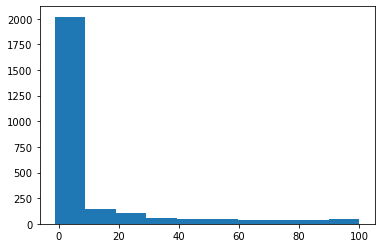

In [28]:
import matplotlib.pyplot as plt

# plt.boxplot(true_yields)
# plt.hist(true_yields)

print(np.linalg.norm(np.array(true_yields) > 100,1))
print(np.linalg.norm(np.array(true_yields) <= 100,1))

remove_outliers = [k for k in true_yields if k <= 100]
print(len(remove_outliers), len(true_yields))
plt.hist(remove_outliers)

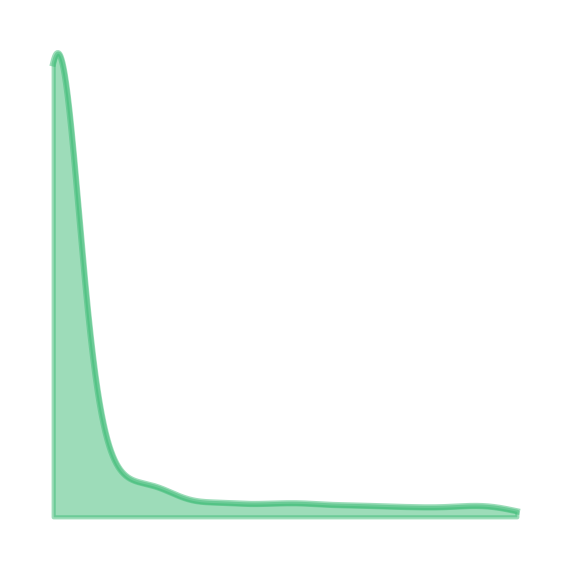

In [12]:
import numpy as np
from scipy import stats

fig, ax = plt.subplots(figsize=(2,2), dpi=300)


kernel = stats.gaussian_kde(remove_outliers)
x = np.arange(0,100,.001)
y = kernel(x)
ax.plot(x,y, alpha=0.5, c="#3CBB75")
ax.fill_between(x,y,0, color='#3CBB75', interpolate=True, alpha=0.5)
ax.set_yticks([])
ax.set_xticks([])
plt.axis('off')

plt.tight_layout()
plt.savefig(f"kde_all.png",dpi=900, bbox_inches='tight',pad_inches=0.0)


In [21]:
from sklearn.manifold import TSNE

X_TSNE_RFP = TSNE(n_components=2, n_jobs=-1).fit_transform(remove_outlier_fp)


/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [22]:
print(len(X_TSNE_RFP), len(data[reagent_classes[0]]))

2569 2786


In [28]:
data["x"] = []
data["y"] = []
for k in X_TSNE_RFP[:,0]:
    data["x"].append(k) 
for k in X_TSNE_RFP[:,1]:
    data["y"].append(k)
for k in reagent_classes:
    print(len(data[k]))
print(len(data["x"]))
print(len(data["y"]))
df = pd.DataFrame(data)

2786
2786
2786
2786
2786
2786
2786


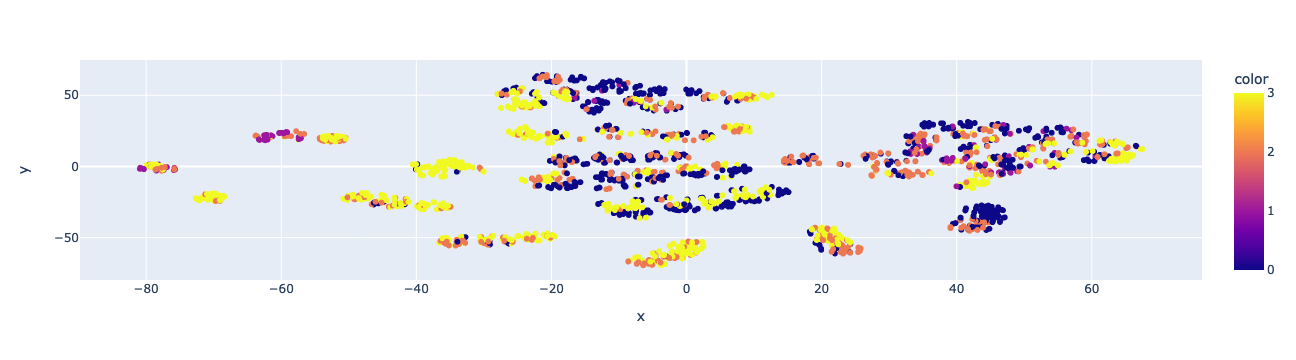

In [29]:
import plotly.express as px
fig = px.scatter(df, x="x", y="y", hover_data=['catalyst_smiles', 'electrophile', 'nucleophile', 'base_smiles', 'solvent'], color=yields)
fig.show()

In [43]:
i = 0
cluster_sets = {k:[] for k in reagent_classes}
for x,y in zip(df["x"], df["y"]):
    if x < -65 and x > -75 and y < -19 and y > -25:
        for k in reagent_classes:
            # print(k, df[k][i])
            if df[k][i] not in cluster_sets[k]:
                cluster_sets[k].append(df[k][i])
    i = i + 1
for k in cluster_sets:
    print(k, len(cluster_sets[k]))
    if k == "catalyst_smiles" or k == "base_smiles":
        for j in cluster_sets[k]:
            print(j, smiles_to_name[j])

electrophile 1
nucleophile 1
catalyst_smiles 6
[Pd](OS(=O)(=O)C)c1c(c2c(N)cccc2)cccc1.P(c1c(c2c(cc(cc2C(C)C)C(C)C)C(C)C)cccc1)(C1CCCCC1)C1CCCCC1 XPhos Pd G3
[Pd](OS(=O)(=O)C)c1c(c2c(N)cccc2)cccc1.P(c1c(c2c(cc(cc2C(C)C)C(C)C)C(C)C)cccc1)(C(C)(C)C)C(C)(C)C tBuXPhos Pd G3
[Pd](OS(=O)(=O)C)c1c(c2c(N)cccc2)cccc1.P(c1c(c2c(cc(cc2C(C)C)C(C)C)C(C)C)c(OC)ccc1OC)(C(C)(C)C)C(C)(C)C tBuBrettPhos Pd G3
[Pd](OS(=O)(=O)C)c1c(c2c(N)cccc2)cccc1.P(c1c(c2c(cc(cc2C(C)C)C(C)C)C(C)C)c(ccc1OC)C)(C(C)(C)C)C(C)(C)C RockPhos Pd G3
[Pd](OS(=O)(=O)C)c1c(c2c(N)cccc2)cccc1.P(C12CC3CC(C1)CC(C2)C3)(C12CC3CC(C1)CC(C2)C3)c1c(c2c(cc(cc2C(C)C)C(C)C)C(C)C)c(OC)ccc1OC AdBrettPhos Pd G3
[Pd](OS(=O)(=O)C)c1c(c2c(N)cccc2)cccc1.[Fe].P(C(C)(C)C)(C(C)(C)C)[C]1[CH][CH][CH][CH]1.P(C(C)(C)C)(C(C)(C)C)[C]1[CH][CH][CH][CH]1 DTBPF Pd G3
base_smiles 8
C1CCN2CCCN=C2CC1 DBU
CN1CCCN2CCCN=C12 MTBD
CN(C)C(N(C)C)=NC(C)(C)C BTMG
[P]1(N(CC)CC)(=NC(C)(C)C)N(CCCN1C)C BEMP
CC(C)(C)N=[P](N1CCCC1)(N2CCCC2)N3CCCC3 BTTP
[P](N(C)C)(N(C)C)(N(C)C)=NC(C)

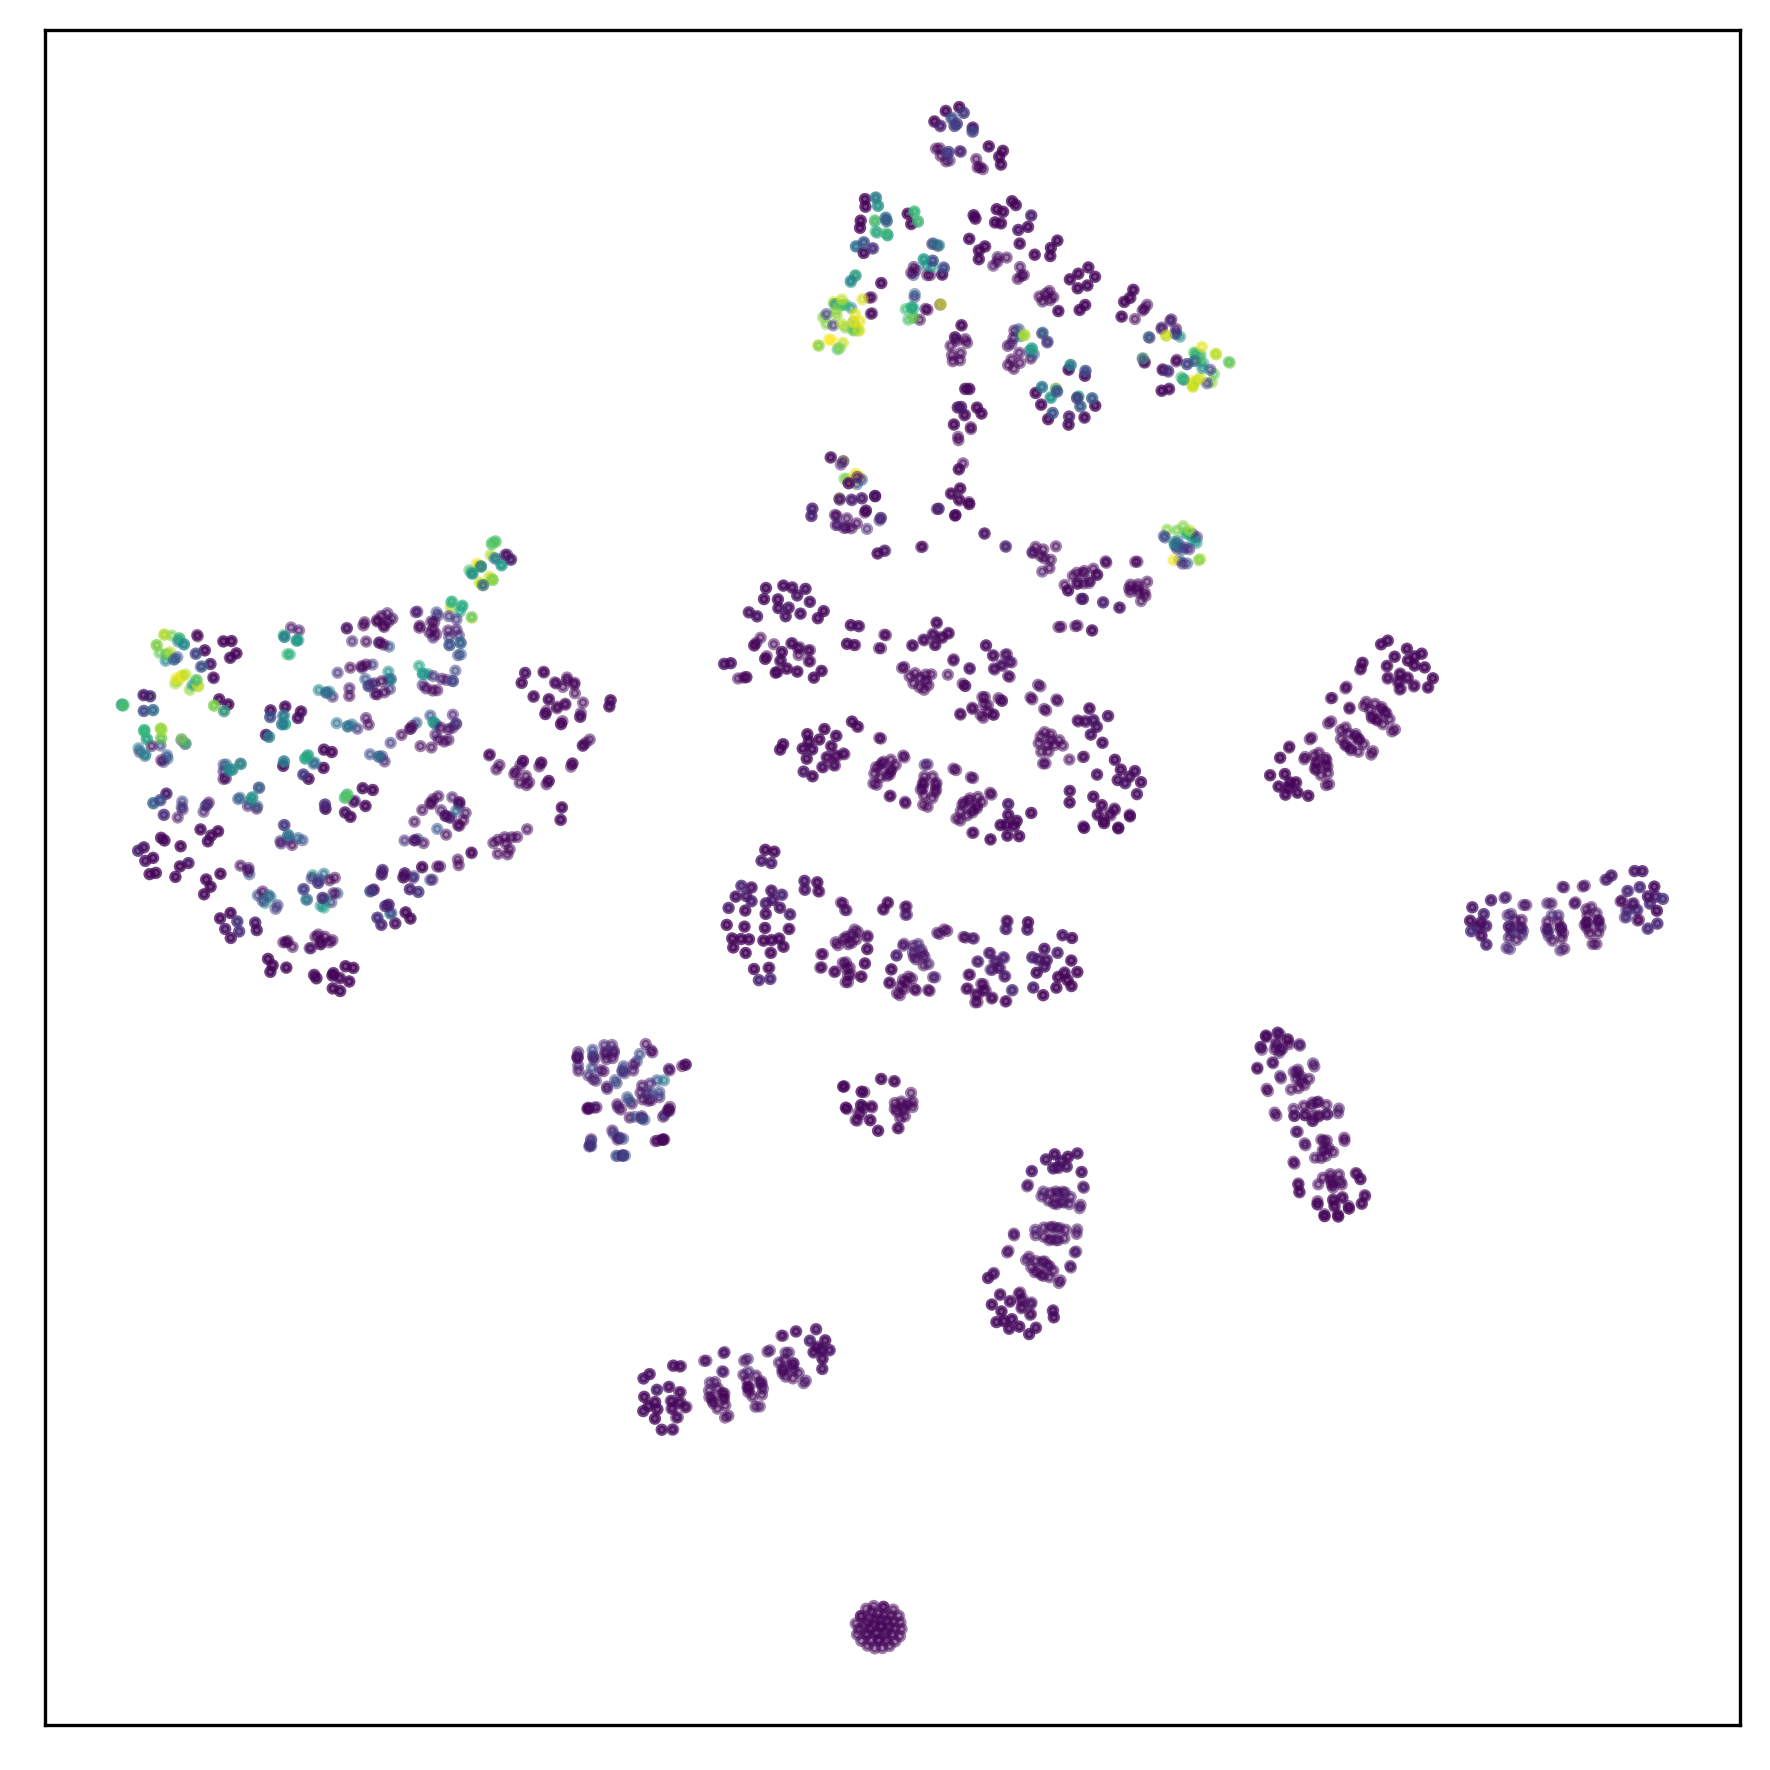

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,6), dpi=300)
ax.scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='viridis', c=remove_outliers, alpha=.5, marker='.',s=15)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.savefig('figure1tsne.png', dpi=300, bbox_inches='tight',pad_inches=0.0)

In [120]:
from sklearn.decomposition import PCA

reagent_tsnes = {}
avg_yields_by_class = {}
for k in reagent_classes:
    all_fps = [ordered_smiles_by_class[k][j] for j in ordered_smiles_by_class[k]]
    avg_yields_by_class[k] = []
    for j in ordered_smiles_by_class[k]:
        avg_yields_by_class[k].append(np.mean(yields_split_by_class[k][j]))
    # reagent_tsnes[k] = TSNE(n_components=2, n_jobs=-1).fit_transform(all_fps)
    reagent_tsnes[k] = PCA(n_components=2).fit_transform(all_fps)

15


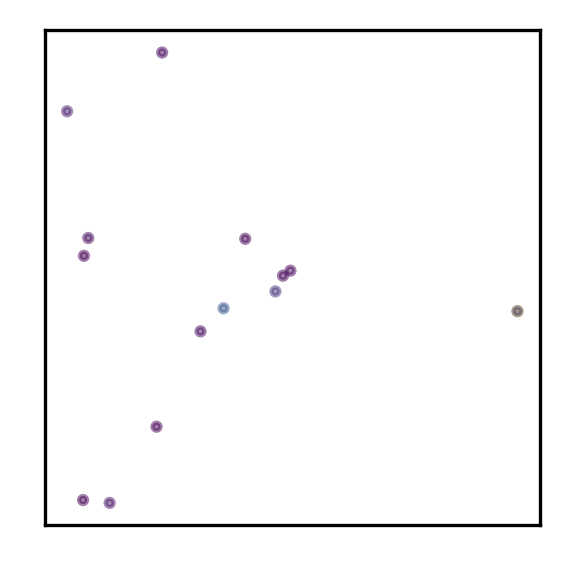

In [121]:
fig, ax = plt.subplots(figsize=(2,2), dpi=300)
ax.scatter(reagent_tsnes["electrophile"][:,0], reagent_tsnes["electrophile"][:,1], cmap='viridis', c=avg_yields_by_class["electrophile"], alpha=.5, marker='.',s=15)

print(len(reagent_tsnes["electrophile"][:,0]))
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()

plt.savefig('electrophile_tsne.png', dpi=300, bbox_inches='tight',pad_inches=0.0)

In [122]:
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm

def surrogate(model, X):
    # catch any warning generated when making a prediction
    with catch_warnings():
        # ignore generated warnings
        simplefilter("ignore")
        return model.predict(X, return_std=True)

def acquisition(X, Xsamples, model):
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)
    # print(mu)
    mu = mu
    # calculate the probability of improvement
    probs = norm.cdf((mu - best) / (std+1E-9))
    return probs


In [ ]:
from warnings import catch_warnings
from warnings import simplefilter


for comp in reagent_classes:
    X_embedded = reagent_tsnes[comp]
    avg_yields = avg_yields_by_class[comp]


    model = GaussianProcessRegressor()
    model.fit(X_embedded, np.array(avg_yields))

    X1samples = np.asarray(np.arange(np.min(X_embedded[:,0]), np.max(X_embedded[:,0]), 0.1))
    X2samples = np.asarray(np.arange(np.min(X_embedded[:,1]), np.max(X_embedded[:,1]), 0.1))
    Xsamples = []
    for x1 in X1samples:
        for x2 in X2samples:
            Xsamples.append([x1,x2])
    # Xsamples = Xsamples.reshape(len(Xsamples), 1)
    ysamples, _ = surrogate(model, Xsamples)
    scores = acquisition(X_embedded, Xsamples, model)
    Xsamples = np.array(Xsamples)

    x_range = np.max(Xsamples[:,0]) - np.min(Xsamples[:,0])
    y_range = np.max(Xsamples[:,1]) - np.min(Xsamples[:,1])


    fig, ax = plt.subplots(figsize=(2,2), dpi=300)
    ax.scatter(Xsamples[:,0], Xsamples[:,1], cmap='viridis', c=scores, alpha=.15, marker='.',s=15, vmax=np.max(scores), zorder=-1)

    ax.scatter(reagent_tsnes[comp][:,0], reagent_tsnes[comp][:,1], cmap='viridis', c=avg_yields_by_class[comp], alpha=.5, marker='.',s=15)

    print(len(reagent_tsnes[comp][:,0]))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

    plt.savefig(f'{comp}_pca_ei.png', dpi=300, bbox_inches='tight',pad_inches=0.0)

ValueError: Found input variables with inconsistent numbers of samples: [2569, 15]

15
34
18
8
8


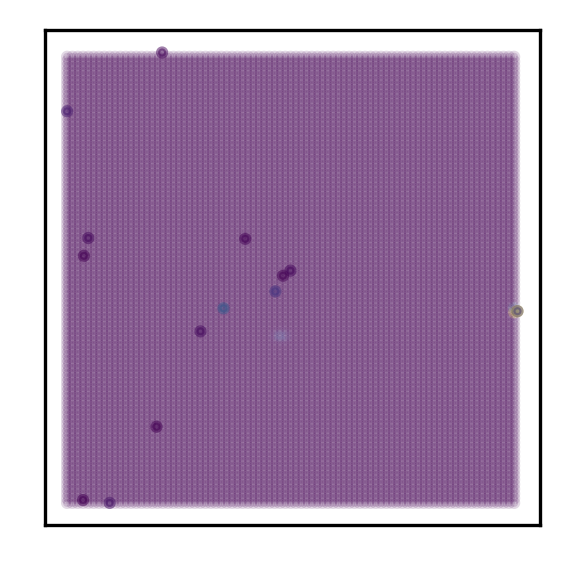

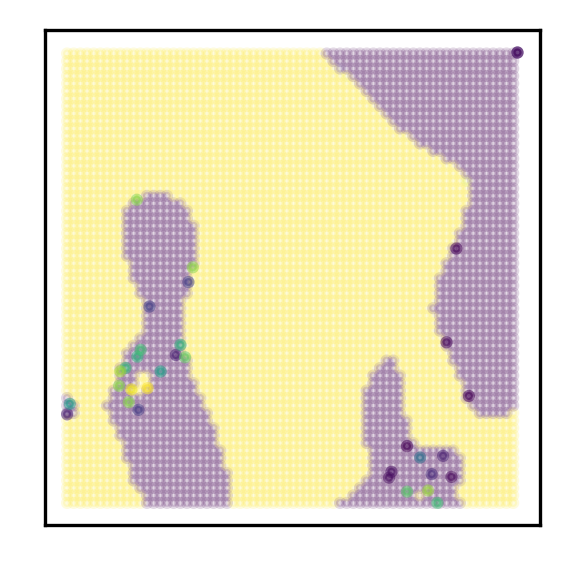

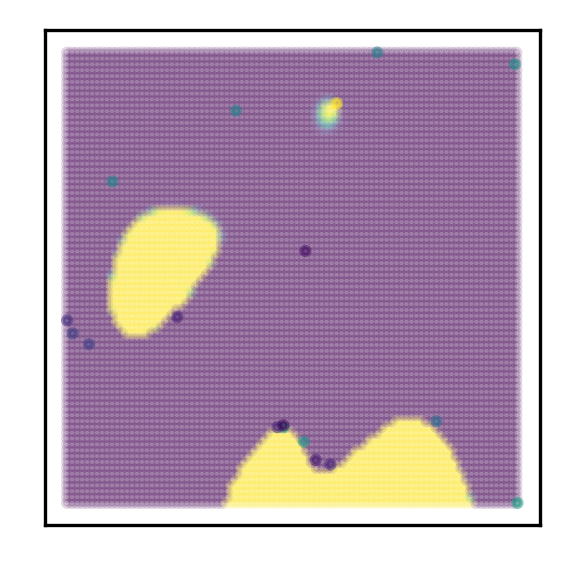

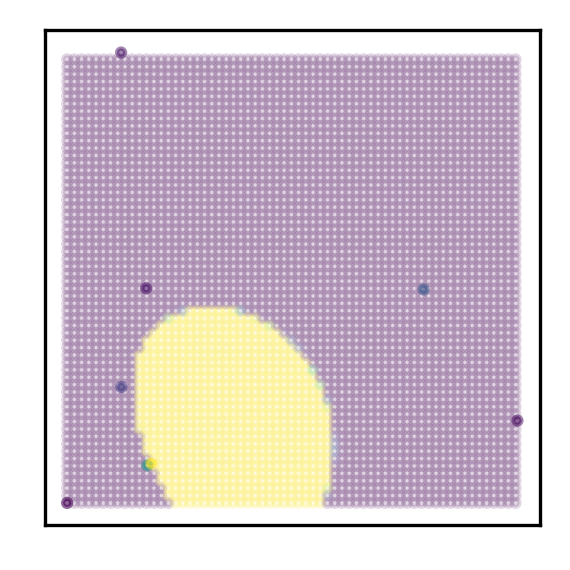

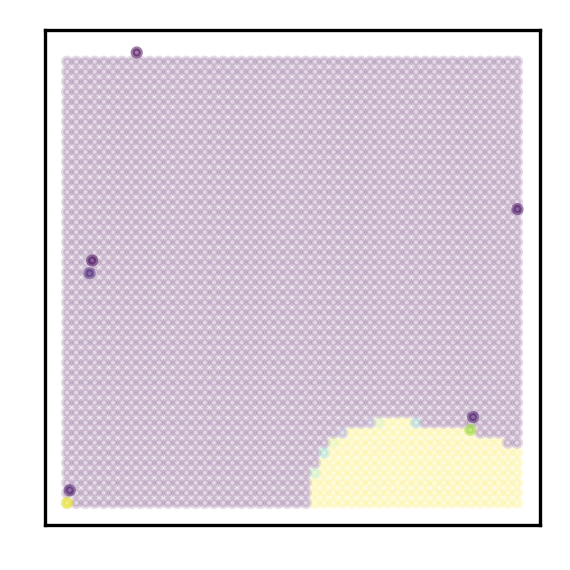

In [123]:
from warnings import catch_warnings
from warnings import simplefilter


for comp in reagent_classes:
    X_embedded = reagent_tsnes[comp]
    avg_yields = avg_yields_by_class[comp]


    model = GaussianProcessRegressor()
    model.fit(X_embedded, np.array(avg_yields))

    X1samples = np.asarray(np.arange(np.min(X_embedded[:,0]), np.max(X_embedded[:,0]), 0.1))
    X2samples = np.asarray(np.arange(np.min(X_embedded[:,1]), np.max(X_embedded[:,1]), 0.1))
    Xsamples = []
    for x1 in X1samples:
        for x2 in X2samples:
            Xsamples.append([x1,x2])
    # Xsamples = Xsamples.reshape(len(Xsamples), 1)
    ysamples, _ = surrogate(model, Xsamples)
    scores = acquisition(X_embedded, Xsamples, model)
    Xsamples = np.array(Xsamples)

    x_range = np.max(Xsamples[:,0]) - np.min(Xsamples[:,0])
    y_range = np.max(Xsamples[:,1]) - np.min(Xsamples[:,1])


    fig, ax = plt.subplots(figsize=(2,2), dpi=300)
    ax.scatter(Xsamples[:,0], Xsamples[:,1], cmap='viridis', c=scores, alpha=.15, marker='.',s=15, vmax=np.max(scores), zorder=-1)

    ax.scatter(reagent_tsnes[comp][:,0], reagent_tsnes[comp][:,1], cmap='viridis', c=avg_yields_by_class[comp], alpha=.5, marker='.',s=15)

    print(len(reagent_tsnes[comp][:,0]))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

    plt.savefig(f'{comp}_pca_ei.png', dpi=300, bbox_inches='tight',pad_inches=0.0)

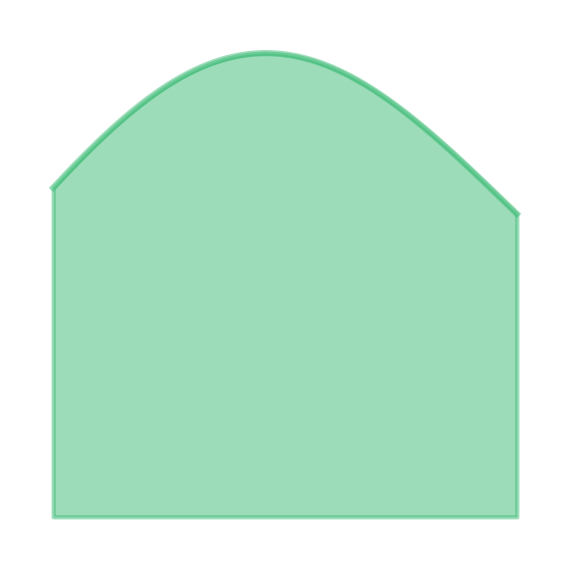

In [93]:
import numpy as np
from scipy import stats

fig, ax = plt.subplots(figsize=(2,2), dpi=300)


kernel = stats.gaussian_kde(remove_outliers)
x = np.arange(np.min(reagent_tsnes["electrophile"][:,0]),np.max(reagent_tsnes["electrophile"][:,0]),.001)
y = kernel(x)
ax.plot(x,y, alpha=0.5, c="#3CBB75")
ax.fill_between(x,y,0, color='#3CBB75', interpolate=True, alpha=0.5)
ax.set_yticks([])
ax.set_xticks([])
plt.axis('off')

plt.tight_layout()
plt.savefig(f"kde_electrophile_x.png",dpi=900, bbox_inches='tight',pad_inches=0.0)


In [101]:
multipliers = [1, 1, 1, 1, 3]
rxnfps_cat_3 = []
types = []
for k in r:
    if "Suzuki" not in k.reaction_name:
        continue
    fp = getRxnFP(k, "MFP4", True, multipliers)
    types.append(k.base)
    rxnfps_cat_3.append(fp)
print(len(rxnfps_cat_3), len(yields))

2786 2786


In [102]:
type_list = []
for k in types:
    if k not in type_list:
        type_list.append(k)
types_one_hot = [type_list.index(k) for k in types]
for k in type_list:
    print(k)

K3PO4
BTMG
P2Et
BTTP
MTBD
Cs2CO3
DBU
BEMP
P1-t-Octyl
P2-t-Bu


In [84]:
X_TSNE_RFP_CAT_3 = TSNE(n_components=2, n_jobs=-1).fit_transform(rxnfps_cat_3)

/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


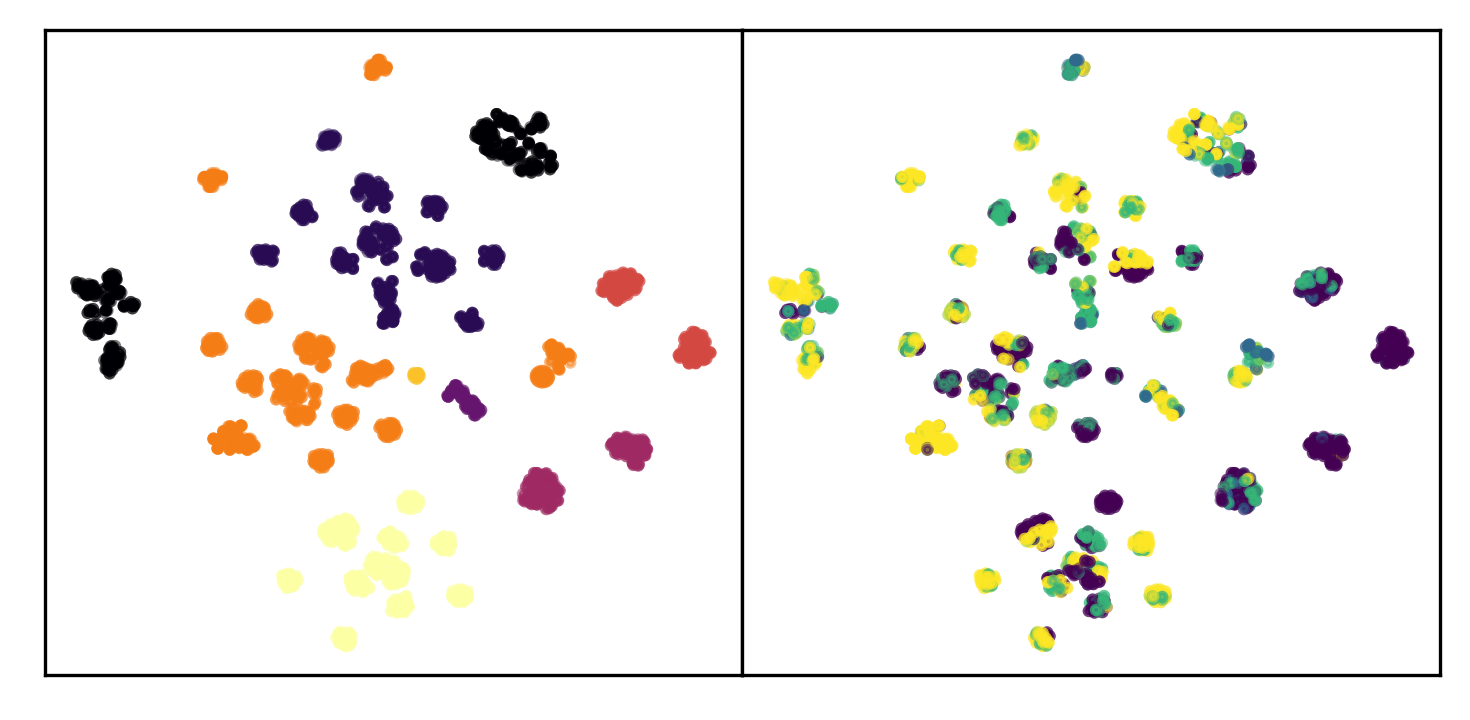

In [100]:
fig, ax = plt.subplots(1,2,figsize=(5,2.5), dpi=300)

ax[0].scatter(X_TSNE_RFP_CAT_3[:,0], X_TSNE_RFP_CAT_3[:,1], cmap='inferno', c=types_one_hot, alpha=.5, marker='.',s=15)
ax[1].scatter(X_TSNE_RFP_CAT_3[:,0], X_TSNE_RFP_CAT_3[:,1], cmap='viridis', c=yields, alpha=.5, marker='.',s=15)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
# ax[0].legend()
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('figure2/figure2tsne.png', dpi=300, bbox_inches='tight')